In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from odtlearn.fair_oct import FairSPOCT
from odtlearn.utils.binarize import Binarizer, binarize


# Fair Optimal Classification Trees

## Introduction
The goal of this notebook is to demonstrate how users can utilize the FairOCT classes in the ODTlearn package to learn fair optimal classification trees. We will focus on the FairSPOCT class, which enforces statistical parity, and show how different parameter values affect the learned tree structure and fairness metrics. Additionally, we will introduce other fairness metrics available in the package.



## Loan Approval Dataset

In this example, we generate a synthetic dataset related to loan approval decisions. The dataset has 5 features: Age, Income, Credit_Score, Employment_Status, Education_Level, and Previous_Default. The target variable is Loan_Approval, which indicates whether a loan application is approved (1) or denied (0). We also include a protected attribute, Gender, to simulate a fairness-related scenario.

When using the FairSPOCT class to learn fair optimal decision trees, there are several key parameters to consider:

1. depth: This parameter controls the maximum depth of the decision tree. A larger depth allows for more complex trees, but may lead to overfitting. It's recommended to start with a small depth (e.g., 2 or 3) and gradually increase it while monitoring the performance on a validation set.

2. _lambda: This is the regularization parameter that balances the trade-off between accuracy and tree complexity. A higher value of _lambda encourages simpler trees. It's typically set to a small value (e.g., 0.01 or 0.1) to prevent overfitting. You can tune this parameter using cross-validation.

3. fairness_bound: This parameter controls the strictness of the fairness constraint. A value of 1 means no fairness constraint is enforced, while smaller values enforce stricter fairness constraints. The choice of fairness_bound depends on the desired level of fairness and the trade-off with accuracy. It's recommended to start with a value close to 1 and gradually decrease it while monitoring the fairness metrics and accuracy.

The other parameters in the FairSPOCT class include:

- solver: The solver to use for the optimization problem. We use "gurobi" in this example, but you can also use "cbc" for the open-source COIN-OR Branch and Cut solver.
- positive_class: The value of the class label corresponding to the desired outcome. In this case, we set it to 1, representing loan approval.
- time_limit: The maximum time (in seconds) allowed for solving the optimization problem.
- num_threads: The number of threads the solver should use. If set to None, it will use all available threads.
- obj_mode: The objective to be used for learning the optimal decision tree. We set it to "acc" to optimize for accuracy, but you can also use "balance" for balanced accuracy or even "weighted" to specify your own weights for each observation.
- verbose: If set to True, the solver will display verbose output during the optimization process.


In [2]:
n = 100
X, y = make_classification(n_samples=n, n_features=5, n_informative=3,
                            n_redundant=1, n_classes=2, weights=[0.7, 0.3], random_state=42)

# Create a DataFrame with feature names
df = pd.DataFrame(X, columns=['Age', 'Income', 'Credit_Score', 'Employment_Status', 'Education_Level'])
df['Previous_Default'] = np.random.choice([0,1,], size=n, p = [0.9, 0.1])
df['Loan_Approval'] = y

# Add a protected attribute (e.g., Gender)
df['Gender'] = np.random.choice(['Male', 'Female'], size=n, p=[0.6, 0.4])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, gender_train, gender_test, prev_default_train, prev_default_test = train_test_split(
    df.drop(['Loan_Approval', 'Previous_Default', 'Gender'], axis=1),
    df['Loan_Approval'],
    df['Gender'],
    df['Previous_Default'],
    test_size=0.2,
    random_state=42
)


Next we use the `Binarizer` class to transform the features to binary features. Note that many of these features would likely be encoded as categorical or binary features in real data, but for our toy example we will pretend they are all continuous features.

In [3]:
# Binarize continuous features
feat_binarizer = Binarizer(
    real_cols=['Age', 'Income', 'Credit_Score', 'Employment_Status', 'Education_Level']
)
X_train_bin = feat_binarizer.fit_transform(X_train)
X_test_bin = feat_binarizer.transform(X_test)


## Learning Fair Optimal Classification Trees with Statistical Parity

Let's investigate the effect of different fairness bound values on the learned tree structure and fairness metrics.


### Initialize FairSPOCT classifier with a less strict fairness bound

In [15]:
fcl_less_strict = FairSPOCT(
    solver="gurobi",
    positive_class=1,
    depth=3,
    _lambda=0.01,
    time_limit=60,
    fairness_bound=1,
    num_threads=None,
    obj_mode="acc",
    verbose=False,
)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 60


In [16]:
# Fit the classifier
fcl_less_strict.fit(X=X_train_bin,
                    y=y_train.values,
                    protect_feat=gender_train.map({'Male': 0, 'Female': 1}).values.reshape(-1,1),
                    legit_factor=prev_default_train.values)



Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7232 rows, 3785 columns and 29354 nonzeros
Model fingerprint: 0x43381646
Variable types: 30 continuous, 3755 integer (3755 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 56.4300000
Presolve removed 3367 rows and 996 columns
Presolve time: 0.33s
Presolved: 3865 rows, 2789 columns, 19713 nonzeros
Variable types: 28 continuous, 2761 integer (2759 binary)
Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.01s




    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   79.18750    0  401   56.43000   79.18750  40.3%     -    0s
H    0     0                      69.2900000   79.18750  14.3%     -    0s
H    0     0                      70.2600000   79.18750  12.7%     -    0s
     0     0   79.18390    0  655   70.26000   79.18390  12.7%     -    0s
     0     0   79.18000    0  703   70.26000   79.18000  12.7%     -    0s
     0     0   79.18000    0  651   70.26000   79.18000  12.7%     -    1s
     0     0   79.18000    0  644   70.26000   79.18000  12.7%     -    1s
     0     0   79.18000    0  604   70.26000   79.18000  12.7%     -    1s
     0     0   79.17900    0  572   70.26000   79.17900  12.7%     -    1s
H    0     0                      71.2500000   79.17701  11.1%     -    1s
     0     0   79.17701    0  324   71.25000   79.17701  11.1%     -    1s
H    0     0           

FairSPOCT(solver=gurobi,depth=3,time_limit=60,num_threads=None,verbose=False)

The `fit` function is used to train the fair optimal classification tree on the given dataset. It takes the following arguments:

- `X`: The feature matrix containing the predictive features for each instance.
- `y`: The target vector indicating the class labels for each instance.
- `protect_feat`: The protected feature to be used for enforcing fairness constraints. In this example, we use the 'Gender' feature.
- `legit_factor`: The legitimate factor that can justify differences in outcomes across protected groups. In this example, we use the 'Number_of_Defaults' feature as the legitimate factor.

When choosing features for legitimate factors versus predictive features, consider the following:

- Legitimate factors should be variables that are deemed acceptable to influence the outcome, even if they may result in differences across protected groups. These factors should be based on domain knowledge and societal norms. For example, in a loan approval scenario, the number of previous loan defaults might be considered a legitimate factor.

- Predictive features, on the other hand, are variables that are used to make predictions but should not lead to unfair treatment of protected groups. These features should be carefully selected to avoid perpetuating biases or discrimination. For instance, while 'Age' and 'Income' might be predictive of loan approval, they should not be used in a way that unfairly disadvantages certain protected groups.

It is essential to engage with domain experts, stakeholders, and affected communities to determine which features should be considered legitimate factors and which should be used solely for prediction purposes. This helps ensure that the fair optimal classification tree aligns with the specific fairness requirements and societal expectations of the problem at hand.


In addition to looking at the progress log displayed when calling `fit`, we can check optimization statistics by looking at properties such as `optim_gap` and `num_solutions`.

In [17]:
fcl_less_strict.optim_gap

0.0

We also provide a simple function allowing users to plot the search progress log over time. Note that you must set the attribute `store_search_progress_log` to `True` before calling the `fit` method to ensure that the bound information is stored. 

In [ ]:
fcl_progress_example = FairSPOCT(
    solver="gurobi",
    positive_class=1,
    depth=3,
    _lambda=0.01,
    time_limit=60,
    fairness_bound=1,
    num_threads=None,
    obj_mode="acc",
    verbose=False,
)
fcl_progress_example.store_search_progress_log = True

In [ ]:
# Fit the classifier
fcl_progress_example.fit(X=X_train_bin,
                    y=y_train.values,
                    protect_feat=gender_train.map({'Male': 0, 'Female': 1}).values.reshape(-1,1),
                    legit_factor=prev_default_train.values)

Once the optimal decision tree has been fit, you can generate a customizable a plot of the upper and lower bounds by calling the `plot_search_progress` method.

<AxesSubplot:title={'center':'Search Progress'}, xlabel='Time (s)', ylabel='Objective Bound'>

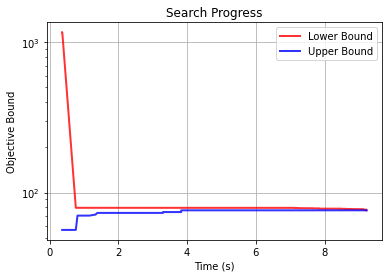

In [19]:
fcl_progress_example.plot_search_progress(log_scale=True)

Next we calculate the fairness metric and accuracy on the test data.

In [20]:
sp_metric = fcl_less_strict.calc_metric(
        protect_feat=gender_test.map({'Male': 0, 'Female': 1}).values.reshape(-1,1),
        y= fcl_less_strict.predict(X_test_bin))

In [8]:
print("Statistical Parity on Testing Set (Less Strict Fairness Bound):")
print(pd.DataFrame(
    sp_metric.items(),
    columns=["(p,y)", "P(Y=y|P=p)"],
))


Statistical Parity on Testing Set (Less Strict Fairness Bound):
    (p,y)  P(Y=y|P=p)
0  (0, 0)    0.928571
1  (1, 0)    0.500000
2  (0, 1)    0.071429
3  (1, 1)    0.500000


In [9]:
test_acc = np.mean(fcl_less_strict.predict(X_test_bin) == y_test)
print(f"Test Accuracy (Less Strict Fairness Bound): {test_acc:.3f}")

Test Accuracy (Less Strict Fairness Bound): 0.850


We can also plot the learned decision tree. Notice that we can pass shorter versions of the feature names to the `plot_tree` method to make the plot easier to read. We can also adjust the distance between levels of the tree using the `distance` argument.

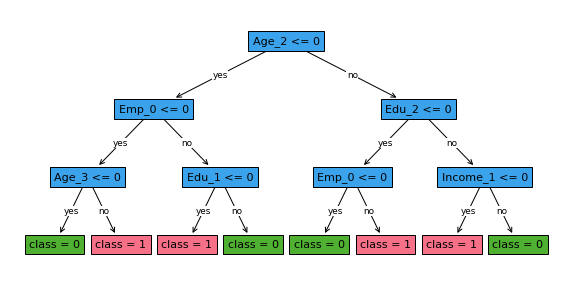

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
fcl_less_strict.plot_tree(ax=ax,
                          feature_names = ['Age_0', 'Age_1', 'Age_2', 'Age_3', 'Income_0', 'Income_1', 'Income_2',
       'Income_3', 'C_0', 'C_1', 'C_2',
       'C_3', 'Emp_0', 'Emp_1',
       'Emp_2', 'Emp_3', 'Edu_0',
       'Edu_1', 'Edu_2', 'Edu_3'],
         distance=0.6)
plt.show()


### Initialize FairSPOCT classifier with a stricter fairness bound

In [11]:
fcl_strict = FairSPOCT(
    solver="gurobi",
    positive_class=1,
    depth=3,
    _lambda=0.01,
    time_limit=60,
    fairness_bound=0.05,
    num_threads=None,
    obj_mode="acc",
    verbose=False,
)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 60


In [12]:
# Fit the classifier
fcl_strict.fit(X=X_train_bin,
                    y=y_train.values,
                    protect_feat=gender_train.map({'Male': 0, 'Female': 1}).values.reshape(-1,1),
                    legit_factor=prev_default_train.values)

Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7232 rows, 3785 columns and 29354 nonzeros
Model fingerprint: 0x7a7d351e
Variable types: 30 continuous, 3755 integer (3755 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 1e+00]
Found heuristic solution: objective 56.4300000
Presolve removed 3367 rows and 968 columns
Presolve time: 0.20s
Presolved: 3865 rows, 2817 columns, 21981 nonzeros
Variable types: 28 continuous, 2789 integer (2787 binary)
Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.06s



FairSPOCT(solver=gurobi,depth=3,time_limit=60,num_threads=None,verbose=False)

Checking the `optim_gap` again:

In [13]:
fcl_strict.optim_gap

0.0

In [14]:
sp_metric = fcl_strict.calc_metric(
        protect_feat=gender_test.map({'Male': 0, 'Female': 1}).values.reshape(-1,1),
        y= fcl_less_strict.predict(X_test_bin))

In [15]:
# Evaluate fairness and accuracy on the testing set
print("Statistical Parity on Testing Set (Stricter Fairness Bound):")
print(pd.DataFrame(
    sp_metric.items(),
    columns=["(p,y)", "P(Y=y|P=p)"],
))


Statistical Parity on Testing Set (Stricter Fairness Bound):
    (p,y)  P(Y=y|P=p)
0  (0, 0)    0.928571
1  (1, 0)    0.500000
2  (0, 1)    0.071429
3  (1, 1)    0.500000


In [16]:
test_acc = np.mean(fcl_strict.predict(X_test_bin) == y_test)
print(f"Test Accuracy (Stricter Fairness Bound): {test_acc:.3f}")


Test Accuracy (Stricter Fairness Bound): 0.850


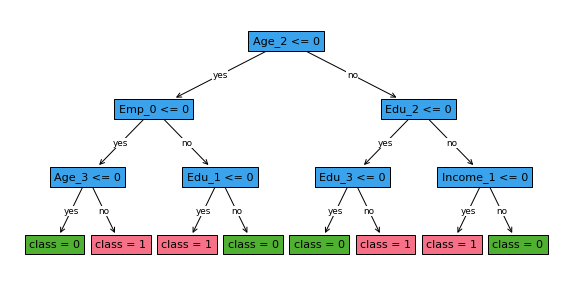

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
fcl_strict.plot_tree(ax=ax,
                          feature_names = ['Age_0', 'Age_1', 'Age_2', 'Age_3', 'Income_0', 'Income_1', 'Income_2',
       'Income_3', 'C_0', 'C_1', 'C_2',
       'C_3', 'Emp_0', 'Emp_1',
       'Emp_2', 'Emp_3', 'Edu_0',
       'Edu_1', 'Edu_2', 'Edu_3'],
         distance=0.6)
plt.show()


Comparing the results of the two FairSPOCT classifiers with different fairness bound values, we can observe the following:

1. The classifier with a less strict fairness bound (0.2) allows for a larger difference in the probability of loan approval between males and females. The statistical parity metric shows that the probability of loan approval is higher for one gender group compared to the other.

2. In contrast, the classifier with a stricter fairness bound (0.05) enforces a much smaller difference in the probability of loan approval between males and females. The statistical parity metric is closer to being equal for both gender groups.

3. The decision trees learned by the two classifiers may differ in structure and the features used for splitting, as the stricter fairness bound constrains the tree learning process to ensure a more balanced outcome across the protected groups.

4. The accuracy of the classifier with a stricter fairness bound may be slightly lower compared to the classifier with a less strict fairness bound. This is because enforcing a stricter fairness constraint can limit the classifier's ability to optimize for accuracy.

These observations demonstrate the trade-off between fairness and accuracy when using fairness constraints in decision tree learning. By adjusting the fairness bound value, users can control the level of fairness enforced in the learned tree, while considering the potential impact on accuracy.




## Additional Supported Fairness Metrics
Now that we have seen how the FairSPOCT class can be used to learn fair optimal classification trees and the impact of the fairness bound on the learned trees and fairness metrics, let's explore the other fairness metrics available in the ODTlearn package.


In the previous sections, we focused on using the FairSPOCT class to learn fair optimal classification trees with statistical parity constraints. However, the ODTlearn package provides implementations for several other fairness metrics, each capturing different aspects of fairness. These include:

- FairCSPOCT: Enforces conditional statistical parity
- FairPEOCT: Enforces predictive equality
- FairEOppOCT: Enforces equal opportunity
- FairEOddsOCT: Enforces equalized odds

Each of these classes follows a similar interface to FairSPOCT, with the main difference being the fairness metric they enforce.

Here's an overview of each fairness metric and how it is calculated:

1. Statistical Parity (FairSPOCT):
   - Definition: A classifier satisfies statistical parity if the probability of receiving a positive outcome is equal across all protected groups.
   - Equation: $P(\hat{Y} = 1 | A = a) = P(\hat{Y} = 1 | A = b), \forall a, b$
   - $\hat{Y}$ is the predicted outcome, and $A$ is the protected attribute.

2. Conditional Statistical Parity (FairCSPOCT):
   - Definition: A classifier satisfies conditional statistical parity if the probability of receiving a positive outcome is equal across all protected groups, conditioned on a set of legitimate factors.
   - Equation: $P(\hat{Y} = 1 | A = a, L = l) = P(\hat{Y} = 1 | A = b, L = l), \forall a, b, l$
   - $\hat{Y}$ is the predicted outcome, $A$ is the protected attribute, and $L$ represents the legitimate factors.

3. Predictive Equality (FairPEOCT):
   - Definition: A classifier satisfies predictive equality if the false positive rates are equal across all protected groups.
   - Equation: $P(\hat{Y} = 1 | Y = 0, A = a) = P(\hat{Y} = 1 | Y = 0, A = b), \forall a, b$
   - $\hat{Y}$ is the predicted outcome, $Y$ is the true outcome, and $A$ is the protected attribute.

4. Equal Opportunity (FairEOppOCT):
   - Definition: A classifier satisfies equal opportunity if the true positive rates are equal across all protected groups.
   - Equation: $P(\hat{Y} = 1 | Y = 1, A = a) = P(\hat{Y} = 1 | Y = 1, A = b), \forall a, b$
   - $\hat{Y}$ is the predicted outcome, $Y$ is the true outcome, and $A$ is the protected attribute.

5. Equalized Odds (FairEOddsOCT):
   - Definition: A classifier satisfies equalized odds if both the true positive rates and false positive rates are equal across all protected groups.
   - Equation: $P(\hat{Y} = 1 | Y = y, A = a) = P(\hat{Y} = 1 | Y = y, A = b), \forall a, b, y \in \{0, 1\}$
   - $\hat{Y}$ is the predicted outcome, $Y$ is the true outcome, and $A$ is the protected attribute.

When applying fairness constraints to a decision tree, it is crucial to carefully choose a fairness metric that aligns with the specific use case and the societal or legal requirements of the problem at hand. Different fairness metrics capture different aspects of fairness and may lead to different trade-offs between fairness and accuracy.

For example, if the goal is to ensure that the overall proportion of positive outcomes is similar across protected groups, statistical parity (FairSPOCT) would be an appropriate choice. However, if the focus is on ensuring that the classifier makes similar mistakes across protected groups, predictive equality (FairPEOCT) might be more suitable.

It is important to note that achieving fairness in machine learning is a complex and ongoing process that requires careful consideration of the societal context, potential biases in the data, and the limitations of the chosen fairness metric. Engaging with domain experts, stakeholders, and affected communities is essential to understand the specific fairness requirements of the problem and select the most appropriate fairness metric or combination of metrics.
